# 网络总体特征

In [133]:
import networkx as nx
import pandas as pd
import numpy as np
# 读取图
G=nx.DiGraph()
nodes = pd.read_csv("data/fb_nodes.csv")
edges = pd.read_csv("data/fb-pages-government.csv")
G.add_nodes_from(nodes["Id"])
G.add_edges_from(edges.apply(lambda x: tuple(x), axis=1).values.tolist())
# 转化无向图
UG = G.to_undirected()
UG.remove_edges_from(nx.selfloop_edges(UG))

FB-GOVERN网络图是否是弱连通图: True
FB-GOVERN网络图是否是强连通图: False
FB-GOVERN网络图的密度: 0.0017964946594574724
FB-GOVERN网络图的平均路径长度: 0.8156462103050091
FB-GOVERN网络图的直径: 10
FB-GOVERN网络图的平均聚类系数: 0.20544211311222643
FB-GOVERN网络图的平均度: 12.676066317131927
FB-GOVERN网络图的度同配系数: 0.06455798855760314


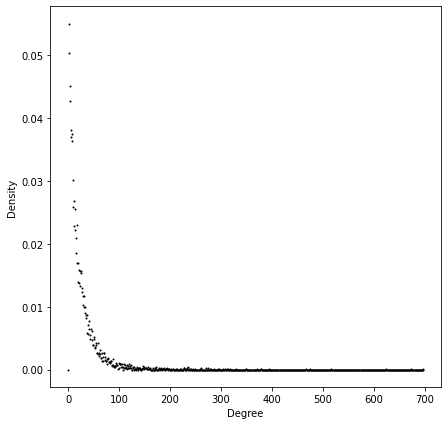

In [111]:
from matplotlib import pyplot as plt
# 计算网络拓扑结构
#判断是否是连通图
print('FB-GOVERN网络图是否是弱连通图:',nx.is_weakly_connected(G))
print('FB-GOVERN网络图是否是强连通图:',nx.is_strongly_connected(G))
#计算密度
print('FB-GOVERN网络图的密度:',nx.density(G))
# 富人俱乐部系数(转化成无向图)
# print('FB-GOVERN网络图的富人俱乐部系数:',nx.rich_club_coefficient(UG))

# 平均路径长度
print('FB-GOVERN网络图的平均路径长度:',nx.average_shortest_path_length(G))
# 直径（无向图，因为图不是强连通，所以有向图的直径为正无穷）
print('FB-GOVERN网络图的直径:',nx.diameter(UG))
# 平均聚类系数
print('FB-GOVERN网络图的平均聚类系数:',nx.average_clustering(G))
# 平均度
degree = pd.DataFrame(G.degree(),columns=["nodes","degree"])
print('FB-GOVERN网络图的平均度:',np.mean(degree["degree"].values)/2)
# 度分布图
degree=nx.degree_histogram(G)
x=range(len(degree))#生成X轴序列，从1到最大度
y=[z/float(sum(degree))for z in degree]#将频次转化为频率，利用列表内涵
plt.figure(figsize=(7,7))
plt.scatter(x,y,s=1,color=(0,0,0))#在双对坐标轴上绘制度分布曲线
plt.xlabel("Degree")
plt.ylabel("Density")
plt.savefig("degree_distribution.png",dpi = 300)#显示图表

#度同配系数
print('FB-GOVERN网络图的度同配系数:',nx.degree_assortativity_coefficient(G))

# 节点重要性度量

In [113]:
G.remove_edges_from(nx.selfloop_edges(G)) #删除自连接边
DC = nx.degree(G) #度中心性 
BC = nx.degree_centrality(G) #介数中心性
CC = nx.closeness_centrality(G) #接近中心性
KC = nx.core_number(G) # k核值(k-core)
EC = nx.eigenvector_centrality(G,max_iter = 500) #特征向量中心性
PR = nx.pagerank(G) #PageRank算法

In [116]:
def get_top(dic,num,name): # 通过name算法,获取的dic中value最大的num个(结点,中心度)对
    sorted_dic = sorted(dict(dic).items(), key=lambda x: x[1],reverse=True)[:num] #将dic强制转化为字典格式并按照value由大到小排序，取出前num个
    data = pd.DataFrame(sorted_dic,columns=['nodes',name]) #转为dataframe格式
    return data.set_index(["nodes"]) #将结点编号作为index
result = pd.concat([get_top(DC,3,"DC"),get_top(BC,3,"BC"),get_top(CC,3,"CC"),get_top(KC,3,"KC"),get_top(EC,3,"EC"),get_top(PR,3,"PR")])
result

,DC,BC,CC,KC,EC,PR
nodes,,,,,,
5320,697.0,NaN,NaN,NaN,NaN,NaN
6615,674.0,NaN,NaN,NaN,NaN,NaN
2141,625.0,NaN,NaN,NaN,NaN,NaN
5320,NaN,0.098781,NaN,NaN,NaN,NaN
6615,NaN,0.095522,NaN,NaN,NaN,NaN
2141,NaN,0.088577,NaN,NaN,NaN,NaN
6615,NaN,NaN,0.291415,NaN,NaN,NaN
4028,NaN,NaN,0.283374,NaN,NaN,NaN
6872,NaN,NaN,0.267894,NaN,NaN,NaN


# 好友推荐

In [127]:
# 构建无向图的边列表
data = pd.DataFrame(UG.edges,columns = ["Source","Target"])
Uedges = pd.concat([data,pd.DataFrame(data.loc[:,["Target","Source"]].values,columns = ["Source","Target"])],axis=0)

In [128]:
from numpy import random
random.seed(1)
targetUsers = pd.DataFrame(random.choice(nodes["Id"], 30), columns=[
                           "Id"])  # 篇幅限制，只给30个随机用户推荐好友
# 关联二度好友
df1 = pd.merge(targetUsers, Uedges, left_on=['Id'], right_on=['Source'])
df2 = pd.merge(df1, Uedges, left_on=['Target'], right_on=['Source'])
friendNum = Uedges.groupby(['Source'])['Target'].count().reset_index()
friendNum.rename(columns={'Target': 'friendNum'}, inplace=True)
df3 = pd.merge(df2, friendNum, left_on='Target_x', right_on='Source')
df3.drop(columns=['Source_x', 'Source_y', 'Source'], inplace=True)
# 将结算结果改名为userID, ffID, CN
df3.rename(columns={'Id': 'userID', 'Target_y': 'ffID',
           'Target_x': 'CN_id', 'friendNum': 'CN_friendNum'}, inplace=True)
# df3包含了二度好友表和共同好友的好友数

# 计算AA_index
df3["AA_index"] = 1/np.log(df3["CN_friendNum"])
df4 = df3.groupby(['userID', 'ffID'])['AA_index'].sum().reset_index()
# 关联好友表，用于标记二度好友是否为好友,已经是好友的删除，推荐自己的删除
df6 = pd.merge(df4, Uedges, how='left', left_on=[
               'userID', 'ffID'], right_on=['Source', 'Target'])
df6 = df6.loc[df6['Target'].isnull(), ['userID', 'ffID', "AA_index"]]
df6 = df6[df6['userID'] != df6['ffID']]
#  按照AAindex排序推荐
df6['rn'] = df6.groupby('userID')['AA_index'].rank(
    ascending=False, method='first')
result = df6.loc[df6['rn'] == 1]
result.drop(columns=['rn'], inplace=True)

c:\Users\zjchenb139\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [129]:
result = pd.DataFrame(result.iloc[:24,:].values.reshape(12,6),columns = ['userID', 'ffID', 'AA_index','userID', 'ffID', 'AA_index'])
print(result.to_latex(index=None,float_format="%.3f",bold_rows = True))

\begin{tabular}{rrrrrr}
\toprule
  userID &     ffID &  AA\_index &   userID &     ffID &  AA\_index \\
\midrule
 310.000 &  390.000 &     0.417 &  741.000 & 2851.000 &    11.895 \\
 780.000 & 1642.000 &     2.069 &  918.000 & 3168.000 &     1.018 \\
1301.000 & 5187.000 &     4.729 & 1320.000 & 4104.000 &     1.570 \\
2264.000 & 4220.000 &     2.452 & 2314.000 & 2011.000 &     1.884 \\
2363.000 &  322.000 &     4.340 & 2746.000 & 4806.000 &     1.796 \\
2763.000 & 2258.000 &     0.910 & 2984.000 &  690.000 &     3.131 \\
3560.000 & 6563.000 &     3.166 & 3627.000 & 2001.000 &     4.488 \\
3716.000 & 3740.000 &     1.897 & 4017.000 &   68.000 &     5.327 \\
4377.000 & 1473.000 &     2.117 & 4444.000 & 1406.000 &     7.884 \\
4560.000 & 5814.000 &     2.981 & 4770.000 & 2083.000 &     1.833 \\
4911.000 &  769.000 &     0.910 & 4995.000 & 5676.000 &     5.442 \\
5056.000 &  386.000 &    12.757 & 5103.000 & 5676.000 &     8.504 \\
\bottomrule
\end{tabular}



### 自行设计

In [130]:
from numpy import random
random.seed(1)
targetUsers = pd.DataFrame(random.choice(nodes["Id"], 30), columns=[
                           "Id"])  # 篇幅限制，只给30个随机用户推荐好友
# 关联二度好友
df1 = pd.merge(targetUsers, Uedges, left_on=['Id'], right_on=['Source'])
df2 = pd.merge(df1, Uedges, left_on=['Target'], right_on=['Source'])
friendNum = Uedges.groupby(['Source'])['Target'].count().reset_index()
friendNum.rename(columns={'Target': 'friendNum'}, inplace=True)
df3 = pd.merge(df2, friendNum, left_on='Target_x', right_on='Source')
df3.drop(columns=['Source_x', 'Source_y', 'Source'], inplace=True)
# 将结算结果改名为userID, ffID, CN
df3.rename(columns={'Id': 'userID', 'Target_y': 'ffID',
           'Target_x': 'CN_id', 'friendNum': 'CN_friendNum'}, inplace=True)
# df3包含了二度好友表和共同好友的好友数

# 计算WBC_index
df3["WBC_index"] = 1/df3["CN_friendNum"]*np.log(df3["CN_friendNum"])
df4 = df3.groupby(['userID', 'ffID'])['WBC_index'].sum().reset_index()
# 关联好友表，用于标记二度好友是否为好友,已经是好友的删除，推荐自己的删除
df6 = pd.merge(df4, Uedges, how='left', left_on=[
               'userID', 'ffID'], right_on=['Source', 'Target'])
df6 = df6.loc[df6['Target'].isnull(), ['userID', 'ffID', "WBC_index"]]
df6 = df6[df6['userID'] != df6['ffID']]
#  按照WBCindex排序推荐
df6['rn'] = df6.groupby('userID')['WBC_index'].rank(
    ascending=False, method='first')
result = df6.loc[df6['rn'] == 1]
result.drop(columns=['rn'], inplace=True)

In [132]:
result = pd.DataFrame(result.iloc[:24,:].values.reshape(12,6),columns = ['userID', 'ffID', 'WBC-index','userID', 'ffID', 'WBC-index'])
print(result.to_latex(index=None,float_format="%.3f",bold_rows = True))

\begin{tabular}{rrrrrr}
\toprule
  userID &     ffID &  WBC-index &   userID &     ffID &  WBC-index \\
\midrule
 310.000 &  390.000 &      0.218 &  741.000 & 1046.000 &      2.441 \\
 780.000 & 1642.000 &      0.803 &  918.000 & 3168.000 &      0.463 \\
1301.000 & 5187.000 &      1.553 & 1320.000 & 4104.000 &      0.791 \\
2264.000 & 4220.000 &      1.140 & 2314.000 & 2011.000 &      0.774 \\
2363.000 &  322.000 &      1.765 & 2746.000 & 4806.000 &      0.553 \\
2763.000 & 2258.000 &      0.366 & 2984.000 &  690.000 &      1.418 \\
3560.000 & 6563.000 &      1.386 & 3627.000 & 2001.000 &      1.610 \\
3716.000 & 3740.000 &      0.505 & 4017.000 &   68.000 &      1.264 \\
4377.000 & 3275.000 &      0.768 & 4444.000 & 1406.000 &      2.553 \\
4560.000 & 5814.000 &      0.877 & 4770.000 & 2083.000 &      0.544 \\
4911.000 &  769.000 &      0.366 & 4995.000 & 5676.000 &      1.866 \\
5056.000 &  386.000 &      4.232 & 5103.000 & 1120.000 &      3.212 \\
\bottomrule
\end{tabular}



# 社团识别

In [80]:
import networkx as nx
import pandas as pd
import numpy as np
import time

# 抽样获得小数据集
G_small=nx.Graph()
nodes = pd.read_csv("data/fb_nodes.csv")
edges = pd.read_csv("data/fb-pages-government.csv")
df1 = pd.merge(nodes,edges,left_on="Id",right_on="Source")
df2 = df1.groupby(['Source'])['Target'].count().reset_index()
df2 = pd.DataFrame(df2.values,columns=["Id","friendNum"])
df2["rn"] = df2["friendNum"].rank(ascending=False, method='first')
# nodes = df2.loc[df2["rn"]<=100,["Id"]]
nodes = pd.DataFrame(np.random.choice(df2["Id"],150,replace=False,p = (1/df2["rn"])/sum(1/df2["rn"])),columns=["Id"])
edges = pd.merge(nodes,edges,left_on="Id",right_on="Source",how = "inner").loc[:,["Source","Target"]]
edges = pd.merge(nodes,edges,left_on="Id",right_on="Target",how = "inner").loc[:,["Source","Target"]]
G_small.add_nodes_from(nodes["Id"])
G_small.add_edges_from(edges.apply(lambda x: tuple(x), axis=1).values.tolist())
# 删除自连接
G_small.remove_edges_from(nx.selfloop_edges(G_small))
# 找出最大连同子图
largest = max(nx.connected_components(G_small),key=len)
G_small = G_small.subgraph(largest)
print("新社交网络节点数",G_small.number_of_nodes())
print("新社交网络边数",G_small.number_of_edges())

新社交网络节点数 121
新社交网络边数 777


In [105]:
from matplotlib import cm # 节点颜色
def draw_plot(G,y,title):
    i = 0
    colors = []
    for node in G.nodes:
        colors.append(cm.Set1(y[i]))
        i+=1
    plt.figure(figsize=(8,8))
    nx.draw(G,pos=nx.spring_layout(G,k = 0.3,seed =1,iterations = 50),node_size=100,node_color=colors,width = 0.3,edge_color = "grey",with_labels=False)
    plt.savefig("{title}.png".format(title = title),dpi = 200)

Kmeans聚类耗时:0.163 s


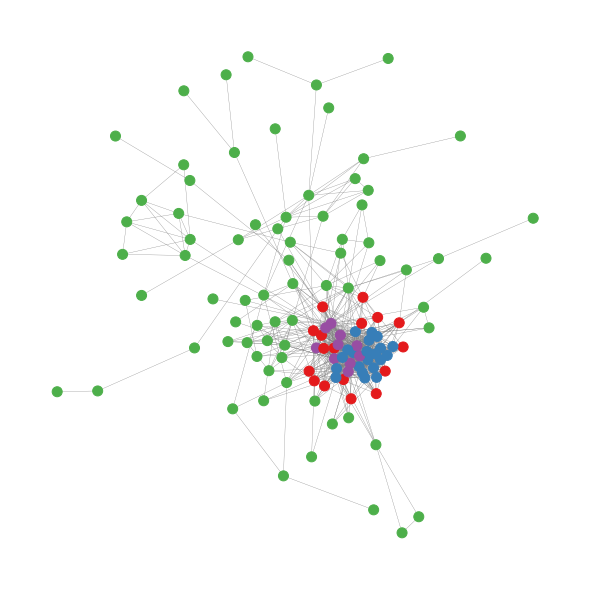

In [97]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
data = nx.adjacency_matrix(G_small).todense()
# Kmeans聚类
start = time.time()
kmeans = KMeans(n_clusters=4, random_state=1).fit(data)
y = kmeans.predict(data)
end = time.time()
draw_plot(G_small,y,"Kmeans聚类")
print("Kmeans聚类耗时:%.3f s"%(end-start))

GN算法耗时:0.876 s


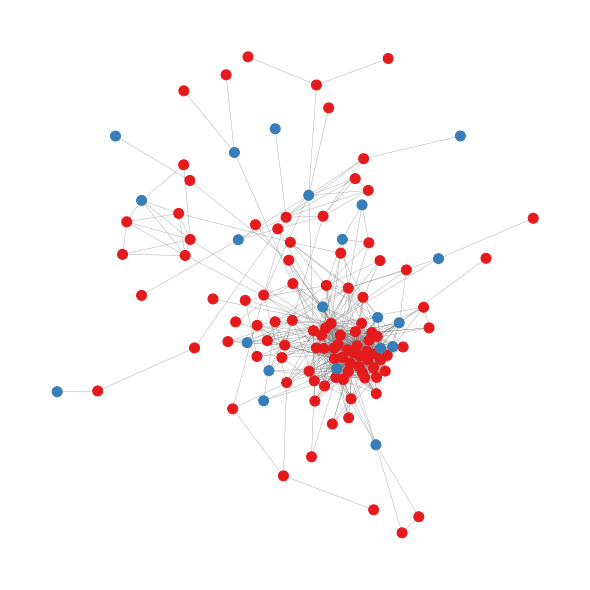

In [107]:
# GN算法
from networkx.algorithms import community
start = time.time()
comp = community.girvan_newman(G_small)# 显示不同划分层级的节点
# gc1 = tuple(sorted(c) for c in next(comp))
y = []
for keys,values in dict(enumerate(next(comp))).items():
    for value in values:
        y.append(keys)
end = time.time()
draw_plot(G_small,y,"GN_model")
print("GN算法耗时:%.3f s"%(end-start))

In [108]:
# 基于Q函数的贪婪算法
from networkx.algorithms import community
start = time.time()
comp = community.greedy_modularity_communities(G_small)# 显示不同划分层级的节点
# gc1 = tuple(sorted(c) for c in next(comp))
y = []
for keys,values in dict(enumerate(next(comp))).items():
    for value in values:
        y.append(keys)
end = time.time()
draw_plot(G_small,y,"Q_model")
print("基于Q函数的贪婪算法耗时:%.3f s"%(end-start))

TypeError: 'list' object is not an iterator